# 4. Image denoising

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.ndimage

In [2]:
def raw_read(imgData):
    nr = 512
    nc = 512
    nchan = 1
    c = 0 #用 c來記錄 raw檔讀取到的 index位置
    img = np.zeros((nr, nc, nchan))
    for i in range(nr):
        for j in range(nc):
            for k in range(0, nchan):
                img[i, j, k] = imgData[c]
                c=c+1
    return img

In [3]:
imgDataNoisy = np.fromfile('data/Noisy.raw', dtype='uint8')
img_Noisy = raw_read(imgDataNoisy).reshape(512, 512)

In [4]:
img_Noisy.shape

(512, 512)

In [5]:
def post_process_image(image):
        """Post process the image to create a full contrast stretch of the image
        takes as input:
        image: the image obtained from the inverse fourier transform
        return an image with full contrast stretch
        -----------------------------------------------------
        1. Full contrast stretch (fsimage)
        2. take negative (255 - fsimage)
        """
        a = 0
        b = 255
        c = np.min(image)
        d = np.max(image)
        rows, columns = np.shape(image)
        image1 = np.zeros((rows, columns), dtype=int)
        for i in range(rows):
            for j in range(columns):
                if (d-c) == 0:
                    image1[i, j] = ((b - a) / 0.000001) * (image[i, j] - c) + a
                else:
                    image1[i, j] = ((b - a) / (d - c)) * (image[i, j] - c) + a

        return np.uint8(image1)

In [6]:
def filtering(img, mask):
    # Compute the fft of the image
    fft = np.fft.fft2(img.copy())

    # shift the fft to center the low frequencies
    shift_fft = np.fft.fftshift(fft)
    mag_dft = np.log(np.abs(shift_fft))
    dft = post_process_image(mag_dft)
    
    # filter the image frequency based on the mask (Convolution theorem)
    filtered_image = np.multiply(mask, shift_fft)
    mag_filtered_dft = np.log(np.abs(filtered_image)+1)
    filtered_dft = post_process_image(mag_filtered_dft)
    
    # compute the inverse shift
    shift_ifft = np.fft.ifftshift(filtered_image)
    
    # compute the inverse fourier transform
    ifft = np.fft.ifft2(shift_ifft)
    
    # compute the magnitude
    mag = np.abs(ifft)
    
    filtered_image = post_process_image(mag)
    
    return np.uint8(filtered_image)

# i. Inverse filter

In [37]:
def inv_filter(img_bgr):
    global restored
    g = img_bgr
    G =  (np.fft.fft2(g))
        
    h = np.random.normal(0, 0.1, img_bgr.shape)
    h_padded = np.zeros(g.shape) 
    h_padded[:h.shape[0],:h.shape[1]] = np.copy(h)
    H = (np.fft.fft2(h_padded))
        
    # normalize to [0,1]
    H_norm = H/abs(H.max())
    G_norm = G/abs(G.max())
    F_temp = G_norm/H_norm
    F_norm = F_temp/abs(F_temp.max())
        
    #rescale to original scale
    F_hat  = F_norm*abs(G.max())
        
    # apply Inverse Filter and compute IFFT
    f_hat = np.fft.ifft2(F_hat)
    restored = abs(f_hat)
    return restored

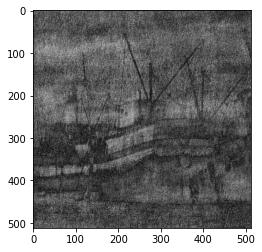

In [38]:
mask = inv_filter(img_Noisy.copy())
plt.imshow(filtering(img_Noisy.copy(), mask), cmap = 'gray')

# ii. Wiener filter

In [21]:
def weiner_filter(img_bgr, K_small):
    global restored

    g = img_bgr
    G =  (np.fft.fft2(g))
        
    # 隨機生成高斯 noise (float + float)
    h = np.random.normal(0, 0.1, img_bgr.shape)
    h_padded = np.zeros(g.shape) 
    h_padded[:h.shape[0],:h.shape[1]] = np.copy(h)
    H =  (np.fft.fft2(h_padded))
        
    #Find the inverse filter term
    weiner_term = (abs(H)**2 + K)/(abs(H)**2)
    H_weiner = H*weiner_term
    # normalize to [0,1]
    H_norm = H_weiner/abs(H_weiner.max())
        
    G_norm = G/abs(G.max())
    F_temp = G_norm/H_norm
    F_norm = F_temp/abs(F_temp.max())
        
    #rescale to original scale
    F_hat  = F_norm*abs(G.max())
        
    f_hat = np.fft.ifft2(F_hat)
    restored = abs(f_hat)
    return restored

max value of abs(H)**2 is  36482.842934893226


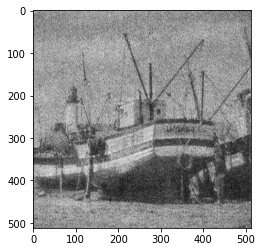

In [36]:
mask = weiner_filter(img_Noisy.copy(), 1.0e-1)
plt.imshow(filtering(img_Noisy.copy(), mask), cmap = 'gray')

# iii. BM3D [1]

In [54]:
import os
import cv2
import time
import sys
from scipy.fftpack import dct, idct
import numpy as np

### Preprocessing

In [55]:
def Initialization(Img, BlockSize, Kaiser_Window_beta):
    
    """
    Initialize the image, weight and Kaiser window
    
    Return:
        InitImg & InitWeight: zero-value Img.shape matrices 
                  InitKaiser: (BlockSize * BlockSize) Kaiser window 
    """

    InitImg = np.zeros(Img.shape, dtype=float)

    InitWeight = np.zeros(Img.shape, dtype=float)

    Window = np.matrix(np.kaiser(BlockSize, Kaiser_Window_beta))

    InitKaiser = np.array(Window.T * Window)            

    return InitImg, InitWeight, InitKaiser

In [56]:
def SearchWindow(Img, RefPoint, BlockSize, WindowSize):

    """ 
    Find the search window whose center is reference block in *Img*
    Note that the center of SearchWindow is not always the reference block because of the border   
    Return:
        (2 * 2) array of left-top and right-bottom coordinates in search window
    """
    
    if BlockSize >= WindowSize:

        print('Error: BlockSize is smaller than WindowSize.\n')

        exit()

    Margin = np.zeros((2,2), dtype = int)

    Margin[0, 0] = max(0, RefPoint[0]+int((BlockSize-WindowSize)/2)) # left-top x
    
    Margin[0, 1] = max(0, RefPoint[1]+int((BlockSize-WindowSize)/2)) # left-top y               
    
    Margin[1, 0] = Margin[0, 0] + WindowSize # right-bottom x
    
    Margin[1, 1] = Margin[0, 1] + WindowSize # right-bottom y             

    if Margin[1, 0] >= Img.shape[0]:

        Margin[1, 0] = Img.shape[0] - 1

        Margin[0, 0] = Margin[1, 0] - WindowSize

    if Margin[1, 1] >= Img.shape[1]:

        Margin[1, 1] = Img.shape[1] - 1

        Margin[0, 1] = Margin[1, 1] - WindowSize
    
    return Margin

In [57]:
def dct2D(A):    
    """
    2D discrete cosine transform (DCT)
    """
    return dct(dct(A, axis = 0, norm = 'ortho'), axis = 1, norm = 'ortho')

In [58]:
def idct2D(A):
    
    """
    inverse 2D discrete cosine transform
    """
    
    return idct(idct(A, axis = 0, norm = 'ortho'), axis = 1, norm = 'ortho') 

In [59]:
def PreDCT(Img, BlockSize):
    
    """
    Do discrete cosine transform (2D transform) for each block in *Img* to reduce the complexity of 
    applying transforms
    Return:
        BlockDCT_all: 4-dimensional array whose first two dimensions correspond to the block's 
                      position and last two correspond to the DCT array of the block
    """
    
    BlockDCT_all = np.zeros((Img.shape[0]-BlockSize, Img.shape[1]-BlockSize, BlockSize, BlockSize),\
                            dtype = float)
    
    for i in range(BlockDCT_all.shape[0]):
        
        for j in range(BlockDCT_all.shape[1]):
            
            Block = Img[i:i+BlockSize, j:j+BlockSize]
            
            BlockDCT_all[i, j, :, :] = dct2D(Block.astype(np.float64))
            
    return BlockDCT_all

In [60]:
def ComputePSNR(Img1, Img2):
    
    """
    Compute the Peak Signal to Noise Ratio (PSNR) in decibles(dB).        
    """
    
    if Img1.size != Img2.size:
        
        print('ERROR: two images should be in same size in computing PSNR.\n')
        
        sys.exit()
    
    Img1 = Img1.astype(np.float64)
    
    Img2 = Img2.astype(np.float64)
    
    RMSE = np.sqrt(np.sum((Img1-Img2)**2)/Img1.size)
    
    return 20*np.log10(255./RMSE)

### Basic estimate

In [61]:
def Step1_Grouping(noisyImg, RefPoint, BlockDCT_all, BlockSize, ThreDist, MaxMatch, WindowSize):

    """
    Find blocks similar to the reference one in *noisyImg* based on *BlockDCT_all*
    
    Note that the distance computing is chosen from original paper rather than the analysis one
    Return:
          BlockPos: array of blocks' position (left-top point)
        BlockGroup: 3-dimensional array whose last two dimensions correspond to the DCT array of 
                     the block
    """
      

    # initialization
    
    WindowLoc = SearchWindow(noisyImg, RefPoint, BlockSize, WindowSize)
    
    Block_Num_Searched = (WindowSize-BlockSize+1)**2                    # number of searched blocks
                         
    BlockPos = np.zeros((Block_Num_Searched, 2), dtype = int)
    
    BlockGroup = np.zeros((Block_Num_Searched, BlockSize, BlockSize), dtype = float)

    Dist = np.zeros(Block_Num_Searched, dtype = float)
    
    RefDCT = BlockDCT_all[RefPoint[0],RefPoint[1], :, :]
    
    match_cnt = 0


    # Block searching and similarity (distance) computing

    for i in range(WindowSize-BlockSize+1):

        for j in range(WindowSize-BlockSize+1):
            
            SearchedDCT = BlockDCT_all[WindowLoc[0, 0]+i, WindowLoc[0, 1]+j, :, :]

            dist = Step1_ComputeDist(RefDCT, SearchedDCT)

            if dist < ThreDist:

                BlockPos[match_cnt, :] = [WindowLoc[0, 0]+i, WindowLoc[0, 1]+j]
                
                BlockGroup[match_cnt, :, :] = SearchedDCT

                Dist[match_cnt] = dist

                match_cnt += 1
                
    
    if match_cnt <= MaxMatch:

        # less than MaxMatch similar blocks founded, return similar blocks
        
        BlockPos = BlockPos[:match_cnt, :]
        
        BlockGroup = BlockGroup[:match_cnt, :, :]
    
    else:

        # more than MaxMatch similar blocks founded, return MaxMatch similarest blocks

        idx = np.argpartition(Dist[:match_cnt], MaxMatch)  # indices of MaxMatch smallest distances

        BlockPos = BlockPos[idx[:MaxMatch], :]
        
        BlockGroup = BlockGroup[idx[:MaxMatch], :]
    
    return BlockPos, BlockGroup

In [62]:
def Step1_ComputeDist(BlockDCT1, BlockDCT2):

    """
    Compute the distance of two DCT arrays *BlockDCT1* and *BlockDCT2* 
    """
    
    if BlockDCT1.shape != BlockDCT1.shape:
        
        print('ERROR: two DCT Blocks are not at the same shape in step1 computing distance.\n')
        
        sys.exit()
        
    elif BlockDCT1.shape[0] != BlockDCT1.shape[1]:
        
        print('ERROR: DCT Block is not square in step1 computing distance.\n')
        
        sys.exit()
    
    BlockSize = BlockDCT1.shape[0]
    
    if sigma > 40:

        ThreValue = lamb2d * sigma

        BlockDCT1 = np.where(abs(BlockDCT1) < ThreValue, 0, BlockDCT1)

        BlockDCT2 = np.where(abs(BlockDCT2) < ThreValue, 0, BlockDCT2)

    return np.linalg.norm(BlockDCT1 - BlockDCT2)**2 / (BlockSize**2)

In [63]:
def Step1_3DFiltering(BlockGroup):
    
    """
    Do collaborative hard-thresholding which includes 3D transform, noise attenuation through 
    hard-thresholding and inverse 3D transform
    
    Return:
        BlockGroup
    """

    ThreValue = lamb3d * sigma
    
    nonzero_cnt = 0
    
    # since 2D transform has been done, we do 1D transform, hard-thresholding and inverse 1D 
    # transform, the inverse 2D transform is left in aggregation processing
    
    for i in range(BlockGroup.shape[1]):

        for j in range(BlockGroup.shape[2]):

            ThirdVector = dct(BlockGroup[:, i, j], norm = 'ortho') # 1D DCT

            ThirdVector[abs(ThirdVector[:]) < ThreValue] = 0.

            nonzero_cnt += np.nonzero(ThirdVector)[0].size

            BlockGroup[:, i, j] = list(idct(ThirdVector, norm = 'ortho'))

    return BlockGroup, nonzero_cnt


In [64]:
def Step1_Aggregation(BlockGroup, BlockPos, basicImg, basicWeight, basicKaiser, nonzero_cnt):
    
    """
    Compute the basic estimate of the true-image by weighted averaging all of the obtained 
    block-wise estimates that are overlapping
    
    Note that the weight is set accroding to the original paper rather than the BM3D analysis one
    """

    if nonzero_cnt < 1:

        BlockWeight = 1.0 * basicKaiser
    
    else:
        
        BlockWeight = (1./(sigma**2 * nonzero_cnt)) * basicKaiser

    for i in range(BlockPos.shape[0]):
        
        basicImg[BlockPos[i, 0]:BlockPos[i, 0]+BlockGroup.shape[1],\
                 BlockPos[i, 1]:BlockPos[i, 1]+BlockGroup.shape[2]]\
                                 += BlockWeight * idct2D(BlockGroup[i, :, :])

        basicWeight[BlockPos[i, 0]:BlockPos[i, 0]+BlockGroup.shape[1],\
                    BlockPos[i, 1]:BlockPos[i, 1]+BlockGroup.shape[2]] += BlockWeight


In [65]:
def BM3D_Step1(noisyImg):
    
    """
    Give the basic estimate after grouping, collaborative filtering and aggregation
    
    Return:
        basic estimate basicImg
    """

    # preprocessing
    
    BlockSize = Step1_BlockSize
    
    ThreDist = Step1_ThreDist
    
    MaxMatch = Step1_MaxMatch
    
    WindowSize = Step1_WindowSize 

    spdup_factor = Step1_spdup_factor

    basicImg, basicWeight, basicKaiser = Initialization(noisyImg, BlockSize, Kaiser_Window_beta)
    
    BlockDCT_all = PreDCT(noisyImg, BlockSize)


    # block-wise estimate with speed-up factor 

    for i in range(int((noisyImg.shape[0]-BlockSize)/spdup_factor)+2):

        for j in range(int((noisyImg.shape[1]-BlockSize)/spdup_factor)+2):

            RefPoint = [min(spdup_factor*i, noisyImg.shape[0]-BlockSize-1), \
                        min(spdup_factor*j, noisyImg.shape[1]-BlockSize-1)]

            BlockPos, BlockGroup = Step1_Grouping(noisyImg, RefPoint, BlockDCT_all, BlockSize, \
                                                  ThreDist, MaxMatch, WindowSize)
            
            BlockGroup, nonzero_cnt = Step1_3DFiltering(BlockGroup)

            Step1_Aggregation(BlockGroup, BlockPos, basicImg, basicWeight, basicKaiser, nonzero_cnt)

    basicWeight = np.where(basicWeight == 0, 1, basicWeight)
    
    basicImg[:, :] /= basicWeight[:, :]

#    basicImg = (np.matrix(basicImg, dtype=int)).astype(np.uint8)

    return basicImg

### Final estimate

In [66]:
def Step2_Grouping(basicImg, noisyImg, RefPoint, BlockSize, ThreDist, MaxMatch, WindowSize, 
                   BlockDCT_basic, BlockDCT_noisy):

    """
    Similar to Step1_Grouping, find the similar blocks to the reference one from *basicImg*
    
    Return:
                BlockPos: array of similar blocks' position (left-top point)
        BlockGroup_basic: 3-dimensional array standing for the stacked blocks similar to the 
                          reference one from *basicImg* after 2D DCT
        BlockGroup_noisy: the stacked blocks from *noisyImg* corresponding to BlockGroup_basic 
    """
    # initialization (same as Step1)
    
    WindowLoc = SearchWindow(basicImg, RefPoint, BlockSize, WindowSize)
    
    Block_Num_Searched = (WindowSize-BlockSize+1)**2
                         
    BlockPos = np.zeros((Block_Num_Searched, 2), dtype = int)

    BlockGroup_basic = np.zeros((Block_Num_Searched, BlockSize, BlockSize), dtype = float)

    BlockGroup_noisy = np.zeros((Block_Num_Searched, BlockSize, BlockSize), dtype = float)

    Dist = np.zeros(Block_Num_Searched, dtype = float)
    
    match_cnt = 0
    

    # Block searching and similarity (distance) computing
    # Note the distance computing method is different from that of Step1

    for i in range(WindowSize-BlockSize+1):

        for j in range(WindowSize-BlockSize+1):

            SearchedPoint = [WindowLoc[0, 0]+i, WindowLoc[0, 1]+j]

            dist = Step2_ComputeDist(basicImg, RefPoint, SearchedPoint, BlockSize)

            if dist < ThreDist:
                
                BlockPos[match_cnt, :] = SearchedPoint

                Dist[match_cnt] = dist

                match_cnt += 1
                
#    if match_cnt == 1:
#        
#        print('WARNING: no similar blocks founded for the reference block {} in final estimate.\n'\
#              .format(RefPoint))
         
    if match_cnt <= MaxMatch:

        # less than MaxMatch similar blocks founded, return similar blocks
        
        BlockPos = BlockPos[:match_cnt, :]
    
    else:

        # more than MaxMatch similar blocks founded, return MaxMatch similarest blocks

        idx = np.argpartition(Dist[:match_cnt], MaxMatch)  # indices of MaxMatch smallest distances

        BlockPos = BlockPos[idx[:MaxMatch], :]
        
    for i in range(BlockPos.shape[0]):
        
        SimilarPoint = BlockPos[i, :]
        
        BlockGroup_basic[i, :, :] = BlockDCT_basic[SimilarPoint[0], SimilarPoint[1], :, :]
        
        BlockGroup_noisy[i, :, :] = BlockDCT_noisy[SimilarPoint[0], SimilarPoint[1], :, :]
        
    BlockGroup_basic = BlockGroup_basic[:BlockPos.shape[0], :, :]
    
    BlockGroup_noisy = BlockGroup_noisy[:BlockPos.shape[0], :, :]

    return BlockPos, BlockGroup_basic, BlockGroup_noisy 

In [67]:
def Step2_ComputeDist(img, Point1, Point2, BlockSize):
    
    """
    Compute distance between blocks whose left-top margins' coordinates are *Point1* and *Point2*        
    """
    
    Block1 = (img[Point1[0]:Point1[0]+BlockSize, Point1[1]:Point1[1]+BlockSize]).astype(np.float64)
    
    Block2 = (img[Point2[0]:Point2[0]+BlockSize, Point2[1]:Point2[1]+BlockSize]).astype(np.float64)
    
    return np.linalg.norm(Block1-Block2)**2 / (BlockSize**2)

In [68]:
def Step2_3DFiltering(BlockGroup_basic, BlockGroup_noisy):

    """
    Do collaborative Wiener filtering and here we choose 2D DCT + 1D DCT as the 3D transform which 
    is the same with the 3D transform in hard-thresholding filtering
    Note that the Wiener weight is set accroding to the BM3D analysis paper rather than the original 
    one
    Return:
       BlockGroup_noisy & WienerWeight
    """
    Weight = 0
    
    coef = 1.0 / BlockGroup_noisy.shape[0]
    
    for i in range(BlockGroup_noisy.shape[1]):
        
        for j in range(BlockGroup_noisy.shape[2]):
            
            Vec_basic = dct(BlockGroup_basic[:, i, j], norm = 'ortho')
            
            Vec_noisy = dct(BlockGroup_noisy[:, i, j], norm = 'ortho')
            
            Vec_value = Vec_basic**2 * coef
            
            Vec_value /= (Vec_value + sigma**2) # pixel weight
            
            Vec_noisy *= Vec_value
            
            Weight += np.sum(Vec_value)
#            for k in range(BlockGroup_noisy.shape[0]):
#                
#                Value = Vec_basic[k]**2 * coef
#                
#                Value /= (Value + sigma**2) # pixel weight 
#                
#                Vec_noisy[k] = Vec_noisy[k] * Value
#                
#                Weight += Value
            
            BlockGroup_noisy[:, i, j] = list(idct(Vec_noisy, norm = 'ortho'))
    
    if Weight > 0:
    
        WienerWeight = 1./(sigma**2 * Weight)
    
    else:
        
        WienerWeight = 1.0
                
    return BlockGroup_noisy, WienerWeight

In [69]:
def Step2_Aggregation(BlockGroup_noisy, WienerWeight, BlockPos, finalImg, finalWeight, finalKaiser):
    
    """
    Compute the final estimate of the true-image by aggregating all of the obtained local estimates 
    using a weighted average 
    """
    BlockWeight = WienerWeight * finalKaiser

    for i in range(BlockPos.shape[0]):
        
        finalImg[BlockPos[i, 0]:BlockPos[i, 0]+BlockGroup_noisy.shape[1],\
                 BlockPos[i, 1]:BlockPos[i, 1]+BlockGroup_noisy.shape[2]]\
                                 += BlockWeight * idct2D(BlockGroup_noisy[i, :, :])

        finalWeight[BlockPos[i, 0]:BlockPos[i, 0]+BlockGroup_noisy.shape[1],\
                    BlockPos[i, 1]:BlockPos[i, 1]+BlockGroup_noisy.shape[2]] += BlockWeight

In [70]:
def BM3D_Step2(basicImg, noisyImg):
    
    """
    Give the final estimate after grouping, Wiener filtering and aggregation
    Return:
        final estimate finalImg
    """
    # parameters setting
    
    BlockSize = Step2_BlockSize
    
    ThreDist = Step2_ThreDist
    
    MaxMatch = Step2_MaxMatch
    
    WindowSize = Step2_WindowSize 

    spdup_factor = Step2_spdup_factor

    finalImg, finalWeight, finalKaiser = Initialization(basicImg, BlockSize, Kaiser_Window_beta)
    
    BlockDCT_noisy = PreDCT(noisyImg, BlockSize)
    
    BlockDCT_basic = PreDCT(basicImg, BlockSize)


    # block-wise estimate with speed-up factor

    for i in range(int((basicImg.shape[0]-BlockSize)/spdup_factor)+2):
        for j in range(int((basicImg.shape[1]-BlockSize)/spdup_factor)+2):
            
            RefPoint = [min(spdup_factor*i, basicImg.shape[0]-BlockSize-1), \
                        min(spdup_factor*j, basicImg.shape[1]-BlockSize-1)]

            BlockPos, BlockGroup_basic, BlockGroup_noisy = Step2_Grouping(basicImg, noisyImg, \
                                                                          RefPoint, BlockSize, \
                                                                          ThreDist, MaxMatch, \
                                                                          WindowSize, \
                                                                          BlockDCT_basic, \
                                                                          BlockDCT_noisy)

            BlockGroup_noisy, WienerWeight = Step2_3DFiltering(BlockGroup_basic, BlockGroup_noisy)

            Step2_Aggregation(BlockGroup_noisy, WienerWeight, BlockPos, finalImg, finalWeight, \
                              finalKaiser)
    
    finalWeight = np.where(finalWeight == 0, 1, finalWeight)
    finalImg[:, :] /= finalWeight[:, :]
    #  finalImg = (np.matrix(finalImg, dtype=int)).astype(np.uint8)
    return finalImg

### main

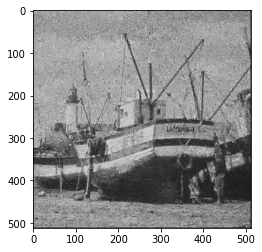

In [71]:
#================================== Parameters initialization ==================================
    
sigma = 25 # variance of the noise
lamb2d = 2.0
lamb3d = 2.7
    
Step1_ThreDist = 2500 # threshold distance
    
Step1_MaxMatch = 16 # max matched blocks
    
Step1_BlockSize = 8
    
Step1_spdup_factor = 3 # pixel jump for new reference block
    
Step1_WindowSize = 39 # search window size  
    
Step2_ThreDist = 400
    
Step2_MaxMatch = 32
    
Step2_BlockSize = 8
    
Step2_spdup_factor = 3
    
Step2_WindowSize = 39

Kaiser_Window_beta = 2.0

#================================== BM3D ==================================
basic_img = BM3D_Step1(img_Noisy.copy())   
#basic_PSNR = ComputePSNR(img, basic_img)
#print('The PSNR of basic image is {} dB.\n'.format(basic_PSNR))
basic_img_uint = np.zeros(img_Noisy.shape)
cv2.normalize(basic_img, basic_img_uint, 0, 255, cv2.NORM_MINMAX, dtype=-1)
basic_img_uint = basic_img_uint.astype(np.uint8)
plt.imshow(basic_img_uint, cmap='gray')

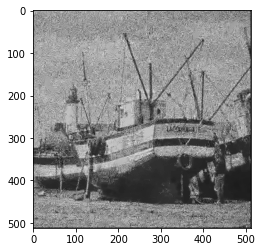

In [73]:
final_img = BM3D_Step2(basic_img, img_Noisy)
    
#final_PSNR = ComputePSNR(img, final_img)

#print('The PSNR of final image is {} dB.\n'.format(final_PSNR))
cv2.normalize(final_img, final_img, 0, 255, cv2.NORM_MINMAX, dtype=-1)
final_img = final_img.astype(np.uint8)
plt.imshow(final_img, cmap='gray')

# iv. Guided Filter [2]

In [7]:
def box(img, r):
    """ O(1) box filter
        img - >= 2d image
        r   - radius of box filter
    """
    (rows, cols) = img.shape[:2]
    imDst = np.zeros_like(img)


    tile = [1] * img.ndim
    tile[0] = r
    imCum = np.cumsum(img, 0)
    imDst[0:r+1, :, ...] = imCum[r:2*r+1, :, ...]
    imDst[r+1:rows-r, :, ...] = imCum[2*r+1:rows, :, ...] - imCum[0:rows-2*r-1, :, ...]
    imDst[rows-r:rows, :, ...] = np.tile(imCum[rows-1:rows, :, ...], tile) - imCum[rows-2*r-1:rows-r-1, :, ...]

    tile = [1] * img.ndim
    tile[1] = r
    imCum = np.cumsum(imDst, 1)
    imDst[:, 0:r+1, ...] = imCum[:, r:2*r+1, ...]
    imDst[:, r+1:cols-r, ...] = imCum[:, 2*r+1 : cols, ...] - imCum[:, 0 : cols-2*r-1, ...]
    imDst[:, cols-r: cols, ...] = np.tile(imCum[:, cols-1:cols, ...], tile) - imCum[:, cols-2*r-1 : cols-r-1, ...]

    return imDst

In [8]:
def _gf_color(I, p, r, eps, s=None):
    """ Color guided filter
    I - guide image (rgb)
    p - filtering input (single channel)
    r - window radius
    eps - regularization (roughly, variance of non-edge noise)
    s - subsampling factor for fast guided filter
    """
    fullI = I
    fullP = p
    if s is not None:
        I = sp.ndimage.zoom(fullI, [1/s, 1/s, 1], order=1)
        p = sp.ndimage.zoom(fullP, [1/s, 1/s], order=1)
        r = round(r / s)

    h, w = p.shape[:2]
    N = box(np.ones((h, w)), r)

    mI_r = box(I[:,:,0], r) / N
    mI_g = box(I[:,:,1], r) / N
    mI_b = box(I[:,:,2], r) / N

    mP = box(p, r) / N

    # mean of I * p
    mIp_r = box(I[:,:,0]*p, r) / N
    mIp_g = box(I[:,:,1]*p, r) / N
    mIp_b = box(I[:,:,2]*p, r) / N

    # per-patch covariance of (I, p)
    covIp_r = mIp_r - mI_r * mP
    covIp_g = mIp_g - mI_g * mP
    covIp_b = mIp_b - mI_b * mP

    # symmetric covariance matrix of I in each patch:
    #       rr rg rb
    #       rg gg gb
    #       rb gb bb
    var_I_rr = box(I[:,:,0] * I[:,:,0], r) / N - mI_r * mI_r;
    var_I_rg = box(I[:,:,0] * I[:,:,1], r) / N - mI_r * mI_g;
    var_I_rb = box(I[:,:,0] * I[:,:,2], r) / N - mI_r * mI_b;

    var_I_gg = box(I[:,:,1] * I[:,:,1], r) / N - mI_g * mI_g;
    var_I_gb = box(I[:,:,1] * I[:,:,2], r) / N - mI_g * mI_b;

    var_I_bb = box(I[:,:,2] * I[:,:,2], r) / N - mI_b * mI_b;

    a = np.zeros((h, w, 3))
    for i in range(h):
        for j in range(w):
            sig = np.array([
                [var_I_rr[i,j], var_I_rg[i,j], var_I_rb[i,j]],
                [var_I_rg[i,j], var_I_gg[i,j], var_I_gb[i,j]],
                [var_I_rb[i,j], var_I_gb[i,j], var_I_bb[i,j]]
            ])
            covIp = np.array([covIp_r[i,j], covIp_g[i,j], covIp_b[i,j]])
            a[i,j,:] = np.linalg.solve(sig + eps * np.eye(3), covIp)

    b = mP - a[:,:,0] * mI_r - a[:,:,1] * mI_g - a[:,:,2] * mI_b

    meanA = box(a, r) / N[...,np.newaxis]
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, [s, s, 1], order=1)
        meanB = sp.ndimage.zoom(meanB, [s, s], order=1)

    q = np.sum(meanA * fullI, axis=2) + meanB

    return q

In [9]:
def _gf_gray(I, p, r, eps, s=None):
    """ grayscale (fast) guided filter
        I - guide image (1 channel)
        p - filter input (1 channel)
        r - window raidus
        eps - regularization (roughly, allowable variance of non-edge noise)
        s - subsampling factor for fast guided filter
    """
    if s is not None:
        Isub = sp.ndimage.zoom(I, 1/s, order=1)
        Psub = sp.ndimage.zoom(p, 1/s, order=1)
        r = round(r / s)
    else:
        Isub = I
        Psub = p


    (rows, cols) = Isub.shape

    N = box(np.ones([rows, cols]), r)

    meanI = box(Isub, r) / N
    meanP = box(Psub, r) / N
    corrI = box(Isub * Isub, r) / N
    corrIp = box(Isub * Psub, r) / N
    varI = corrI - meanI * meanI
    covIp = corrIp - meanI * meanP


    a = covIp / (varI + eps)
    b = meanP - a * meanI

    meanA = box(a, r) / N
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, s, order=1)
        meanB = sp.ndimage.zoom(meanB, s, order=1)

    q = meanA * I + meanB
    return q

In [10]:
def _gf_colorgray(I, p, r, eps, s=None):
    """ automatically choose color or gray guided filter based on I's shape """
    if I.ndim == 2 or I.shape[2] == 1:
        return _gf_gray(I, p, r, eps, s)
    elif I.ndim == 3 and I.shape[2] == 3:
        return _gf_color(I, p, r, eps, s)
    else:
        print("Invalid guide dimensions:", I.shape)

In [11]:
def guided_filter(I, p, r, eps, s=None):
    """ run a guided filter per-channel on filtering input p
        I - guide image (1 or 3 channel)
        p - filter input (n channel)
        r - window raidus
        eps - regularization (roughly, allowable variance of non-edge noise)
        s - subsampling factor for fast guided filter
    """
    if p.ndim == 2:
        p3 = p[:,:,np.newaxis]

    out = np.zeros_like(p3)
    for ch in range(p3.shape[2]):
        out[:,:,ch] = _gf_colorgray(I, p3[:,:,ch], r, eps, s)
    return np.squeeze(out) if p.ndim == 2 else out

In [12]:
noise = img_Noisy.astype(np.float32) / 255
r = 8
eps = 0.05

noise_smoothed_r2 = guided_filter(noise, noise, 2, eps)
noise_smoothed = guided_filter(noise, noise, r, eps)
noise_smoothed_s4 = guided_filter(noise, noise, r, eps, s=4)

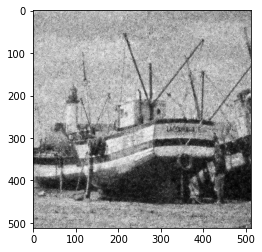

In [14]:
plt.imshow(noise_smoothed_r2, cmap = 'gray')

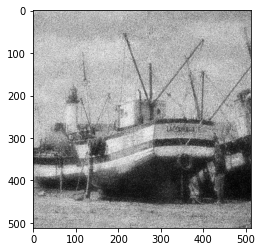

In [13]:
plt.imshow(noise_smoothed, cmap = 'gray')

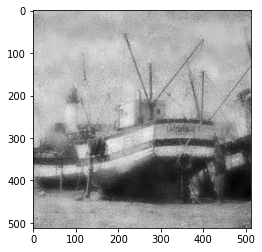

In [52]:
plt.imshow(noise_smoothed_s4, cmap = 'gray')